# Inspiring Confidence and Easing Insecurity in the Pre-election period:

The Effect of Recruiting Military Veterans on Confidence in 2024 US Elections

Isaiah Espinoza (University of Maryland)  
2024-10-16

In [ ]:
set.seed(1234)

# load packages
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

In [ ]:
# custom function used to create Likert Plots

# To avoid excessive copy/paste, I made a function to create Likert plots
# it is mostly a wrapper around `ggstats::gglikert`, but with a specific set up
# particular colors, theme, etc. 
likert_plot <- function(data, x, ...,  
                        symmetric = FALSE,
                        variable_labels = NULL,
                        label_size = 2.5,
                        vline = FALSE,
                        title = waiver(), 
                        subtitle = waiver(),
                        caption = waiver(),
                        xlab = waiver()){
  
  p <- ggstats::gglikert(
    data = data, include = {{ x }}, ...,
    variable_labels = variable_labels,
    symmetric = symmetric)+
    
    # customize color
    ggplot2::scale_fill_grey(start = 0.5, end = 0.1)+
    # custom theme
    theme_bw(base_family = "TeX Gyre Pagella")+
    theme(
      legend.position = 'bottom',  # place legend on bottom
      axis.title.y.left = element_blank(), # blank out y-axis label
      axis.text.x = element_blank(), # remove percentage text along x-axis
      strip.text.y.right = element_text(angle = 0) # make facet label horizontal
        )
    
    if (vline==TRUE) {
    p <- p + geom_vline(xintercept = 0, color = 'black', linewidth = 1.2)
  } else {
      p
  }
  
 
  p <- p + ggplot2::labs(..., title = title, subtitle=subtitle, caption=caption, x = xlab)
  p

}

In [ ]:
# function for creating barplots
custom_barplot <- function(data, x, group, title = NULL, subtitle = NULL,
                           caption = NULL, legend_fill = NULL,
                           xlab = NULL){
  b <- data |> 
    group_by({{ group }}, {{ x }}) |> 
    count() |> 
    drop_na() |> 
    group_by({{ group }}) |> 
  mutate(prop = round(n/sum(n), digits = 3),
         pct = prop*100,
         res = str_c(pct,'% (', n, ')', sep = "")) |> 
  ggplot(aes(x = {{ x }}, y = pct, fill = {{ group }}))+
  geom_bar(position = 'dodge', stat = 'identity')+
  geom_text(aes(label = res), position = position_dodge(1.0), size = 2.5, vjust = -0.7)+
  scale_fill_grey(start = 0.5, end = 0.1)
  
  b <- b + ggplot2::labs(
    title = title,
    subtitle = subtitle,
    caption = stringr::str_wrap(caption, width = 99),
    fill = legend_fill,
    y = "Percentage",
    x = stringr::str_wrap(xlab, width = 85))
  b
}

In [ ]:
# custom function to return a certain selection of logistic regression model
# goodness-of-fit statistics
lrm.gof.stats <- function(x, ...){
  
  out <- data.frame(
    null.deviance = x$null.deviance,
    df.null = x$df.null,
    logLik = as.numeric(stats::logLik(x)),
    AIC = stats::AIC(x),
    BIC = stats::BIC(x),
    deviance = stats::deviance(x),
    df.residual = stats::df.residual(x),
    nobs = stats::nobs(x),
    chisq = as.numeric(x$null.deviance - stats::deviance(x)),
    df = as.numeric(x$df.null - stats::df.residual(x)),
    'P(>chi)' = pchisq(q=x$null.deviance - stats::deviance(x),
                       df = x$df.null - stats::df.residual(x), 
                       lower.tail = F)
  )
  out <- dplyr::as_tibble(out)
  return(out)
}



## Introduction

Election administration officials make efforts to sustain public trust and confidence in the fairness and accuracy of elections, and attempt to boost such confidence where it may be deprived. Concerns for safety have developed among election staff and voters in more recent elections. Regular measures are taken to enhance the *trustworthiness* of the electoral process through practices meant to improve the conduct, transparency, or overall administration of elections in the United States.

Although election officials undertake great efforts to enhance the *trustworthiness* of election administration, public *trust*[1] in elections is a psychological construct influenced by many things outside of election official control such as partisanship or elite rhetoric ([Hooghe 2018](#ref-hooghe2018); [Sances and Stewart 2015](#ref-sances2015)). Moreover, a person’s evaluation of the election in hindsight is often influenced by the election outcome itself ([Daniller and Mutz 2019](#ref-daniller2019); [Stewart 2022](#ref-stewart2022)). Thus, measures taken by election officials can be undermined, trivialized, or made irrelevant depending on how one feels after the election results have come out.

Such volatile attitudes and evaluations post-election can leave a lasting impression that election officials must contend with upon the next election cycle ([Bowler and Donovan 2024](#ref-bowler2024); [Levendusky et al. 2024](#ref-levendusky2024)). For instance, we have witnessed many people’s outright refusal to accept the 2020 U.S. election results as legitimate despite consistent review of the evidence confirming the results as fair and accurate. Such a case demonstrates that public trust in elections is, at best, only partial to trustworthiness of election administration in the United States.

One point of contention that election officials have faced in the past regard evaluation of election workers. Previous literature has focused on how voter interaction with election workers ([Claassen et al. 2008](#ref-claassen2008)), voting technology ([Herrnson, Niemi, and Hanmer 2009](#ref-herrnson2009)), and the voter experience generally ([Atkeson and Saunders 2007](#ref-atkeson2007)), influences evaluations of election administration. As such, election worker competency has been examined as a factor significant to evaluations of performance of elections ([T. Hall, Monson, and Patterson 2007](#ref-hall2007); [T. E. Hall, Quin Monson, and Patterson 2009](#ref-hall2009)). However, considering that individual perceptions and preconceived notions play a huge role in cognition ([Cikara and Bavel 2014](#ref-cikara2014); [Van Bavel and Packer 2021](#ref-vanbavel2021)), it is reasonable to expect that the group an election worker hails from would be an important influence upon the voter’s evaluation of the electoral process.

Supposing such is the case, we can expect that information about *who* (i.e., which groups) election officials are targeting in publicized recruitment efforts would lessen particular election insecurity, and concurrently, boost confidence. That is to say, it is reasonable to expect that telling people *who* will be working and volunteering as election staff would ease election insecurity, and therefore improve confidence that the election will be conducted fairly, accurately, and safe for all involved.

In this paper, I report results from a recent survey experiment administered to test whether publicized efforts to recruit veterans to work as election staff and volunteers would improve public trust in elections and ease election insecurity. Results of the survey experiment support the notion that emphasizing veterans as the target of election worker recruitment efforts eases pre-election insecurity. Expectations of electoral fraud and concerns for voter safety were lower among those who read an announcement that veterans are being recruited to work as election staff and volunteers compared to those who read a control vignette where veterans were not mentioned[2]. Notable is that there was a significant difference in confidence among those in the treatment condition who believe that results of the 2020 election were illegitimate.

This paper is structured as follows. First, I provide a brief background on public trust in election administration. I synthesize a review of relevant literature with a focus on how political and social science has conceptualized and ascertained public trust in elections. Next, I supply reasoning for why military veterans are singled out as the relevant subset of the population in this study. I then explicitly provide the simple theory and testable hypotheses of the study before moving on to describe the design of the survey, the measurement instruments therein, and the conceptual and operational definitions of the variables of interest. I explain my reasoning and method for constructing the primary dependent variable, which I broadly refer to as *confidence in elections*. I close by offering my interpretation of the results and suggest potential avenues for future inquiry.

## Background: Election Administration and Public Confidence

Election officials have tried hard to inspire confidence in the administration and conduct of elections by improving the degree to which elections are trustworthy. Development and implementation of procedures such as post-election auditing of ballots and logic-and-accuracy testing of ballot tabulation equipment are prominent examples adding to the long history of efforts to enhance the trustworthiness of election administration in the United States.

Prior to the year 2000, one of the main issues facing election administration was recruiting enough election workers to volunteer at the polls (i.e., poll workers) ([Maidenberg 1996](#ref-maidenberg1996)). Election worker recruitment is still much of an issue in the current era as it was then, perhaps worse ([Ferrer, Thompson, and Orey 2024](#ref-ferrer2024)). In addition to ensuring election offices were adequately staffed, the controversy of the 2000 general election made the public more attentive to issues concerning the conduct and administration of elections. In particular, voting technology ([Herrnson, Niemi, and Hanmer 2009](#ref-herrnson2009)) and election worker competence was of interest in election studies ([Claassen et al. 2008](#ref-claassen2008); [T. Hall, Monson, and Patterson 2007](#ref-hall2007); [T. E. Hall, Quin Monson, and Patterson 2009](#ref-hall2009)). Following the passage of the Help America Vote Act in 2002, election officials efforts to boost public confidence in the conduct and administration of elections revolved primarily around the accuracy of vote counts, ballot tabulation equipment or voting machines, the commitment of election staff, and more ([Atkeson and Saunders 2007](#ref-atkeson2007)).

In 2024, election officials made valiant efforts to boost public confidence elections within an intensified political climate that appeared quite hostile to election officials ([Brennan Center for Justice 2024](#ref-brennancenterforjustice2024); [Edlin and Norden 2024](#ref-edlin2024)). Although polling around the time indicated that most people thought that U.S. elections would be run at least somewhat well ([Nadeem 2024](#ref-nadeem2024)), many election officials nationwide took efforts to assuage the worry of those most skeptical.

Election anxiety was high in the lead up to the 2024 elections in the United States. Concerns for voter safety and the prospect of political violence remained prescient and compelled many local officials to prepare for the worst ([Doubek 2024](#ref-doubek2024); [Edlin and Norden 2024](#ref-edlin2024)). Election officials in Washoe County, Nevada, installed panic buttons for election staff that would alert a monitoring center to summon law enforcement ([Lincoln 2024](#ref-lincoln2024)). Nevada also passed a law making it a felony to harass, threaten, or intimidate election workers ([Nevada Secretary of State 2023](#ref-nevadasecretaryofstate2023)). Leading up to election day, news outlets reported that election work had become a seemingly dangerous job ([Wire et al. 2024](#ref-wire2024)). A Brennan Center survey report stated that, “…large numbers of election officials report having experienced threats, abuse, or harassment for doing their jobs” ([Edlin and Norden 2024](#ref-edlin2024)). Concerns over the fairness of elections and accuracy of vote counts intensified, heightening concerns over the prospect of political violence and, in turn, increased worry for the safety of voters and election workers alike. Since election worker performance is significant to public evaluation of elections, added safety concerns that drive out election staff and repel volunteers can only detract from trustworthiness of the institution.

## Literature Reivew

Trust and confidence in the conduct of elections concerns aspects of elections that fall squarely within the institution of election administration. At this level, for instance, public trust is ascertained by capturing assessments about the perceived accuracy of vote counts (e.g., whether votes are/were counted as intended).

Intuitively, enhancing public trust in elections would best be accomplished by enhancing the *trustworthiness* of the institution, i.e., consistently doing the things that election officials already regularly do come election time. However, trust and confidence in elections has become ever more precarious over the last few election cycles. Especially considering public polling data since 2000 shows that confidence that votes were, or would be, counted as intended was in a consistent decline despite efforts towards bolstering election integrity and trustworthiness ([Sances and Stewart 2015](#ref-sances2015)). This is even more pronounced considering the role that partisanship has had on such confidence over accuracy of vote count ([Sances and Stewart 2015](#ref-sances2015); [Stewart 2022](#ref-stewart2022)).

There’s also stark difference in public trust before the election has occurred compared to after, a phenomenon referred to as the “winner-loser gap”; the “winners” are those who supported the winning candidate and the “losers” are those who supported the losing candidate. Much research has been dedicated to analyzing the sentiment of electoral winners vs losers, and vice versa ([Daniller and Mutz 2019](#ref-daniller2019); [Nadeau and Blais 1993](#ref-nadeau1993)). Opinions of electoral trust gathered after the election has occurred, however, are limited considering the well-recognized impact that the electoral outcome itself has on feelings of public trust in elections ([Daniller and Mutz 2019](#ref-daniller2019)).

As such, it is questionable whether we can characterize public trust in the pre-election period as the same trust after the election results have come out. The former is *anticipatory*—i.e., the kind that is more or less anxious given the uncertainties surrounding the election. The latter is *empirical*—a judgement discerned in hindsight after the experience of the election event has occurred. As discussed by Stewart ([2022](#ref-stewart2022)), not only was confidence in vote count accuracy influenced by the voter experience, but so too were evaluations of election officials ([2022, 242–43](#ref-stewart2022)). Not to mention the influence that the election results would also have on such evaluations. In other words, trust evaluations post-election are influenced by one’s interpretation of their experience and election results. This study, in contrast, focuses primarily on that *anticipatory* kind of confidence, which speaks more to those insecurities based on perceptions of the institution’s trustworthiness than upon the particular voter experience.

Regardless of the measures taken by election officials to boost public confidence in the *trustworthiness* of election administration (e.g., conducting audits, testing election machines), public *trust* and confidence in elections more generally is apt to shift dramatically post-election based on factors such as partisanship, elite rhetoric, particular state policies, and more ([Carter et al. 2024](#ref-carter2024); [Coll and Clark 2024](#ref-coll2024a); [Nadeau and Blais 1993](#ref-nadeau1993)). Moreover, prior research has found that evaluation of election workers themselves are an important factor when it comes to levels of public confidence in the electoral process ([Claassen et al. 2008](#ref-claassen2008); [T. Hall, Monson, and Patterson 2007](#ref-hall2007); [T. E. Hall, Quin Monson, and Patterson 2009](#ref-hall2009)). Such studies focused on the quality of the voter experience with reference to the interaction between voter and election worker.

Beyond the general competence of election workers, however, the quality of the voter experience may be influenced merely by prior impressions about *who* comprises election staff and volunteers. Political and other social science researchers have recognized for some time the power that group identity can have over attitudes and perception ([Van Bavel and Packer 2021](#ref-vanbavel2021); [Xiao, Coppin, and Van Bavel 2016](#ref-xiao2016); [Xiao and Van Bavel 2012](#ref-xiao2012)). As such, we can expect that information identifying the particular groups being recruited to serve as election staff will be enough to improve trust and confidence in election administration, and lessen expectations of electoral fraud. The next section elaborates on why military veterans are of particular interest in this regard.

## Why Veterans

Election officials are likely to be agnostic as to who dedicates their time to civil service such as election work. Staffing issues have been an issue since at least the 1990s ([Ferrer, Thompson, and Orey 2024](#ref-ferrer2024); [Maidenberg 1996](#ref-maidenberg1996)). In 2020, such efforts were made far more difficult by the COVID-19 pandemic ([Abbate 2020](#ref-abbate2020a); [Mena 2020](#ref-mena2020)). There’s no special reason to target veterans for recruitment above other groups. Indeed, there’s no reason to discriminate recruitment efforts at all if the point is purely to fill staffing vacancies.

The reason why veterans arose as a special subset of the population to consider for this inquiry is because there was a sudden push to target veterans for recruitment efforts that arose shortly after the events on Capitol Hill on January 6th, 2021. After the 2020 election, large efforts were made to recruit military veterans and their families to work or volunteer as election staff ([NFL Football Operations 2022](#ref-nflfootballoperations2022); [We The Veterans 2022](#ref-wetheveterans2022)). Prior to that point, young people were sometimes given special mention as targets of election worker recruitment efforts ([Herndon 2020](#ref-herndon2020); [Power the Polls 2020](#ref-powerthepolls2020)). Generally, however, recruitment efforts cast a wide net, indiscriminate of who applies ([Conde 2020](#ref-conde2020); [Ross 2020](#ref-ross2020)).

One can speculate that the motivation to associate military veterans with civic engagement and democracy may be intended to counter negative perceptions and impressions given by the proportion of veteran service members arrested for taking part in the events on January 6th ([Jensen, Yates, and Kane 2022](#ref-jensen2022a); [Loewenson 2023](#ref-loewenson2023); [Milton and Mines 2021](#ref-milton2021)). Especially with regard to research demonstrating that willingness to support violent efforts to overturn election results (in support of Trump) is, on average, more common among veterans than among matched samples of non-veterans ([Pape et al. 2024](#ref-pape2024)). This is in addition to a strengthened association portrayed in media outlets between military veterans and militias ([Steinhauer 2020](#ref-steinhauer2020)). Prior research has substantiated such a connection between veterans and militia groups. Cooter ([2024](#ref-cooter2024)) notes from her 3-year ethnographic fieldwork among Michigan militia members that, “…approximately 40% of militia leaders and 30% of members had previous military experience. Most of these veterans actively sought out such groups, as opposed to being recruited by them” ([2024](#ref-cooter2024); see also [Cooter 2013](#ref-cooter2013)). Thus, countering such associations by promoting a different image of veterans to the mass public and veterans alike seems like a reasonable motivation. Yet such speculation is just that.

That being said, the general public perception, attitudes, or even stereotypes about military veterans are significant to consider. Although military recruitment shows a downward trend as of late, public perceptions of veterans are overwhelmingly positive ([Kleykamp, Schwam, and Wenig 2023](#ref-kleykamp2023)). Veterans are a particularly potent group where mention of veteran status seems to have a positive, calming, or nullifying effect on attitudes. For instance, recent research shows that, during his campaign in the 2020 Democratic Primaries, Pete Buttigieg’s military background mitigated discrimination against him when he was presented as a veteran married to a man ([Magni and Reynolds 2024](#ref-magni2024)). Similar research has also found that a candidate’s veteran status affords them better evaluations regarding competency in particular issue areas (e.g., war competence) ([Hardy et al. 2019](#ref-hardy2019)). Moreover, veteran status seems to mitigate or nullify usual stigmas associated with mental illness. That is to say, there is negative stigma associated with mental illness ([Corrigan et al. 2002](#ref-corrigan2002)) and such stigma incurs labor market discrimination ([Hipes et al. 2016](#ref-hipes2016)), but evidence suggests that veteran status overrides such stigma and discrimination ([MacLean and Kleykamp 2014](#ref-maclean2014)). Or, in another light, mental illness is seemingly more *understandable* (i.e., permissible) for veterans given the presumptive reasons for their mental strife. And media framing as such plays an important role on public perception ([Kleykamp and Hipes 2015](#ref-kleykamp2015)).

## Theory and Hypotheses

Considering the generally positive perception afforded to veterans by the public, it is reasonable to suspect that efforts that promote recruitment of veterans and their family members to work as election staff and volunteers would boost public *confidence in elections administration*. Indeed, that is the primary hypothesis of this study. Although citizens may vote in various ways across the country (e.g., by mail, ballot drop box, in-person), the simple announcement that election officials are engaging in efforts to recruit veterans to work as election staff may boost confidence in elections administration regardless of how, or whether, an individual plans to vote. Formally,

> H<sub>1</sub>: Announcements that election officials are recruiting miilitary service veterans to work as election staff and volunteers will be associated with greater confidence in elections administration compared to announcements that do not mention military veterans.

Asking participants whether they supported programs intent on recruiting anyone to work as election staff would garner support regardless of the target group. Considering that support and admiration for veterans is generally high among the population ([Kleykamp, Schwam, and Wenig 2023](#ref-kleykamp2023)), then discerning the impact on one’s confidence would require a survey experiment designed to determine whether publicized recruitment efforts targeting veterans as a group would have any special effect on confidence in elections administration.

In addition, prior research has shown that confidence that one’s own vote would be counted as intended has been much stronger than confidence that votes nationwide would be treated likewise ([Sances and Stewart 2015](#ref-sances2015); [Stewart 2022](#ref-stewart2022)). In other words, the public is more trusting of elections closer to home. Taking into account that confidence is lower for elections conducted outside of one’s local area, then information that veterans are being recruited to help conduct elections in locations beyond one’s locale may close this gap between confidence in elections within one’s local area and confidence in elections elsewhere. Although it may be difficult to discern whether recruiting veteran service members would improve confidence in elections near one’s local area in light of such hometown favoritism, a positive effect on confidence in elections held beyond one’s local area—where confidence is already expectedly lower—can help discern the impact of the group alone on public opinion. Therefore, any observed disparity of confidence in elections between those within one’s local area and those beyond will be smaller among those who are presented with information about election official recruitment efforts of veteran service members.

Since the results and events following the 2020 election loomed large in anticipation of the U.S. 2024 general elections, it is reasonable to take into account beliefs about legitimacy of the 2020 election. This group who denies the legitimacy of the 2020 election results were possibly the most apprehensive (distrusting) of the 2024 election. However, given that veteran service members are held in high regard, generally speaking, announcing that veterans are being actively recruited to work as election staff and volunteers is expected to positively influence confidence in elections among those who remained firm in the belief that the 2020 election results were illegitimate. That is to say, despite their belief about the illegitimacy of the 2020 election results, I expect that informing them about veteran recruitment efforts to improve their confidence in elections. I take into account the relationship between partisanship and 2020 election legitimacy beliefs and include partisanship as a control in the analysis[3].

Finally, I expect that concerns about potential for violence will lessen, and confidence in voter safety improve, when presented with information that veterans are being actively recruited to work and volunteer in election offices.

## Experiment Design and Survey Measures

To test the theory that publicized efforts to recruit veterans to work as election staff and volunteers would improve confidence in elections and ease insecurity, a recent experiment was embedded in a survey developed and conducted by the Center for Democracy and Civic Engagement (CDCE) at the University of Maryland. The survey was fielded from August 29th, 2024 to September 18th, 2024 on a non-probability sample of 1,287 U.S. citizens 18 years of age or older. Respondents were randomly split into either the treatment ($n =$ 650) control ($n =$ 637) conditions[4].

Survey participants read either a treatment or control vignette, which resembled a news article about efforts in Maricopa County, AZ to recruit election staff and volunteers for the 2024 general election[5]. The treatment vignette referred to a program designed to recruit veterans and their family members and describes an interviewee “Jordan Braxton” as an Army veteran. The control vignette simply omitted any mention of veterans and their family members, and didn’t describe “Jordan Braxton” as an Army veteran. Beyond those small differences and the headlines, the article vignettes are identical. Therefore, effects can be attributed to the information about veterans in the treatment vignette[6].

It should be noted that Maricopa County, AZ was chosen as the setting of the story in the vignette due to the increased scrutiny levied toward election administration there after the 2020 election ([Giles 2021](#ref-giles2021); [Maricopa County Elections Department 2022](#ref-maricopacountyelectionsdepartment2022)). Because of this, treatment effects are potentially limited or constrained to attitudes concerning the location specified in the vignette. A block of survey items asked specifically about Maricopa County, AZ, followed by an identical block of items that asked the same questions about one’s local area. Later, I compare and discuss results between the items pertaining to different settings.

Over the past two decades it became commonplace for national polls to gauge public confidence in election administration (i.e., voter confidence) by asking some variety of the question, “How confident are you that your vote \[will be/was\] counted as you intended in the most recent election?” ([T. E. Hall, Quin Monson, and Patterson 2009](#ref-hall2009); [Sances and Stewart 2015](#ref-sances2015); [Stewart 2022](#ref-stewart2022)). In addition, since 2008, the Survey of the Performance of American Elections (SPAE) has included a good number of relevant questions to more thoroughly assess trust and confidence in election administration. Such questions inquire into the voter experience with the institution more directly. This study borrows, modifies, or takes inspiration from certain question items found within the 2022 SPAE and other survey items from the Pew Research Center’s 2018 American Trends Panel wave 38 ([Dunn 2018](#ref-dunn2018)).

The items in this study all inquire into confidence over one’s expectations in anticipation of upcoming elections. In addition, the survey of this study focused on attitudes regarding election workers such as election officials, staff, and volunteers specific to the location mentioned in the vignette—Maricopa County, AZ—as well as specific to one’s local area[7].

The survey included items that assessed both trust in elections administration and expectations of electoral fraud, referred to simply as *trust* and *distrust*, respectively. Responses from these two sets of items were utilized to construct the primary dependent variable, *confidence in elections*.

Prior to the reading the treatment or control vignette, participants responded to distinct survey items assessing one’s favorability to local election officials (“In general, how favorable or unfavorable is your impression of local election officials?”) and legitimacy of the 2020 election results (“Regardless of whom you supported in the 2020 election, do you think Joe Biden’s election as president was legitimate, or was he not legitimately elected?”). The former presented five response options from “Strongly favorable” to “Strongly unfavorable”; the latter item presented a binary of either “Legitimate” or “Not Legitimate”.

The conventional multiple item assessment of partisanship was included and used to construct a variable of partisanship consisting of three categories: Democrat, Republican, and independent.

Finally, a pair of survey items assessed concerns for potential violence and confidence in voter safety. The pair was asked once in regard to Maricopa County, AZ and again with respect to one’s local area[8].

### Trust and Distrust in Elections

A set of five survey items measured public trust in elections by inquiring into the degree of confidence that votes will be counted as voters intend, confidence that electoral systems are secure from technological threats, perceived commitment of election staff, confidence that outcomes will be fair, and confidence that the voting process will be fair. Each item in this series presented four response options from “Not at all \[confident/committed\]”, “Not too \[confident/committed\]”, “Somewhat \[confident/committed\]”, and “Very \[confident/committed\]”. In total, five survey items measure different aspects of trust in elections administration.

[1] I adopt a distinction made between *trustworthiness* and *trust* in elections ([Stewart 2022](#ref-stewart2022)). The “*worthiness*” of one’s trust in the conduct and administration of elections is based on the extent that outcomes of an election reasonably follow the rules prescribed and can be adjudicated as such. The public’s *trust* in elections, however, is amendable to an indefinite number of factors that may be unrelated to the formal structure or procedures of election administration. I can recognize that my car is trustworthy prior to ever driving it because it is structurally sound; I have every reason to deem it *worthy of my trust*. However, I don’t trust my car because I am sure it is haunted.

[2] The vignettes written were based on real news stories

[3] To be clear, I conducted an auxiliary regression analysis to examine the relationship between legitimacy beliefs and party ID. Results revealed a statistically significant relationship between the two variables and thus omitting either would result in biased estimates.

[4] Demographic breakdown of the sample are included in Appendix B.

[5] The article vignettes were written and designed by Michael Hanmer Ph.D and myself with input from We the Veterans, a non-profit organization

[6] Complete text of treatment and control vignettes are included in Appendix A

[7] Note that I refer to the items as either ‘AZ items’ or ‘local items’ in order to distinguish the location in which they pertain.

[8] Survey item wording and responses are included in Appendix A.

In [ ]:
trust_txt <- data |> select(q19, q20, q21, q22, q24) |>
  labelled::set_variable_labels(
    q21 = "How commited do you think election staff and volunteers in Maricopa County, AZ will be to making sure the elections are fair and accurate?"
  ) |> 
  labelled::generate_dictionary() |> 
  dplyr::as_tibble() |> 
  dplyr::select(Trust=label)

distrust_txt <- data |> select(q28_1:q28_5) |>
  labelled::generate_dictionary() |> 
  dplyr::as_tibble() |> 
  dplyr::select(Distrust=label)

conf_items_text <- trust_txt |> 
  mutate(Distrust = pull(distrust_txt))

tinytable::tt(conf_items_text, width = c(.5, .5)) |> 
  tinytable::style_tt(fontsize = 0.80)
# kableExtra::kbl(conf_items_text, booktabs = T,
#                 col.names = c("Trust", "Distrust"),
#                 linesep = "\\addlinespace") |> 
#   kableExtra::kable_styling(full_width = T,
#                             font_size = 8,
#                             latex_options = c("HOLD_position")) |> 
#   kableExtra::column_spec(column = 1:2, width = "8cm")

Another series of five survey items captured an individual’s level of *distrust* in elections administration based on the extent to which they expect electoral fraud to occur. These items were prefaced with the question, “How likely do you think any or all of the following will happen during this year´s elections in \[Maricopa County, AZ/ your local area\]?” Each item presented four response options: “Not likely at all”, “Not too likely”, “Somewhat likely”, and “Very likely”.

Similar to the items capturing trust in elections (<a href="#tbl-1" class="quarto-xref">Table 1</a>), I computed a summated score for each respondent reflecting the extent of their distrust in elections.

Upon construction of the two summated scales of *trust* and *distrust*, internal consistency reliability coefficient $\alpha$ were estimated for both and found to be adequate ($\alpha$ \> 0.8); the trust in elections scale $\alpha$ = 0.93 and the distrust scale $\alpha$ = 0.86. In other words, the items in each of the scales were intercorrelated well enough for each to compose a single scale presuming a unidimensional construct for each[1].

## Data Specification

The primary outcome of interest concerns public confidence in elections administration compensated by one’s distrust in elections, i.e., their expectations of electoral fraud. Because trust and distrust are assessed by multiple Likert items, conventional methods call for combining the items of each set into separate Likert scales (also known as summated rating scales). However, many of the items comprising the trust scale directly oppose items capturing distrust. For instance, one item from the trust scale has the respondent report their confidence that votes will be counted as voter’s intend, whereas a separate item from the distrust scale has the the respondent report their expectation that many votes will not be counted. Positive responses to these two items directly contradict each other, and would thus cancel out.

In light of this, I reverse coded items on the distrust scale and combined responses to the trust in elections scale. That is, item responses on the trust scale ranged from 0 (“Not confident at all”) to 3 (“Very confident), whereas responses on the distrust scale ranged from 0 (”Not likely at all”) to -3 (“Very likely”). Combining responses in this way resulted in an overall measure of *confidence in elections* to serve as the dependent variable[2]. On this scale, positive values reflect higher confidence in elections (e.g., elections will be fair and accurate), negative values reflect greater distrust (i.e., expectation that election fraud will occur), and values closer to zero correspond to an individual’s degree of *insecurity*.

## Results

Once trust and distrust were composed into unified variable of confidence in elections, I examined distribution of the dependent variable followed by analysis of the effect of the treatment by comparison of mean differences between experiment conditions. To retain a meaningful zero, I rescaled the sum scores to range from -3 to 3[3] and then superimposed two histograms of confidence scores: one derived from AZ items and another for scores derived from local area items (<a href="#fig-dist" class="quarto-xref">Figure 1</a>). Doing this is illustrative of the relative distribution of confidence that differed depending on the location of elections referred to in the survey items (e.g., Maricopa County, AZ). As expected, the distribution of confidence differed depending on whether survey items pertained to elections in Maricopa County, AZ, or elections within one’s local area.

``` python
ggplot(data) +
  geom_histogram(
    aes(x = conf.az.rescaled , y = after_stat(density)),
    bins = 15,
    alpha = 0.2,
    color = 1,
    fill = "red"
  ) +
  geom_histogram(
    aes(x = conf.lcl.rescaled , y = after_stat(density)),
    bins = 15,
    alpha = 0.2,
    color = 1,
    fill = "blue"
  ) +
  geom_segment(
    x = round(mean(data$conf.az.rescaled), 2),
    y = 0,
    yend = 0.35,
    color = "firebrick",
    lwd = 1.4,
    linetype = 2
  ) +
  geom_segment(
    x = round(mean(data$conf.lcl.rescaled), 2),
    y = 0,
    yend = 0.35,
    color = "darkblue",
    lwd = 1.4,
    linetype = 2
  ) +
  annotate(
    "text",
    x = round(mean(data$conf.az.rescaled), 2),
    y = 0.40,
    label = paste("AZ =", round(mean(
      data$conf.az.rescaled
    ), 2), "(", round(sd(
      data$conf.az.rescaled
    ), 2), ")"),
    color = "firebrick"
  ) +
  annotate(
    "text",
    x = round(mean(data$conf.lcl.rescaled), 2),
    y = 0.43,
    label = paste("Local area =", round(mean(
      data$conf.lcl.rescaled
    ), 2), "(", round(sd(
      data$conf.lcl.rescaled
    ), 2), ")"),
    color = "darkblue"
  ) +
  labs(
    x = str_wrap("Confidence", width = 85),
    y = "Density",
    caption = str_wrap(
     "Mean (std.dev). Mean difference = 0.33, CI [0.27, 0.38], t = 11.613, data = 1286, p < 0.01",
     width = 95)) +
  theme_bw(base_family = "TeX Gyre Pagella")
```

<figure id="fig-dist">
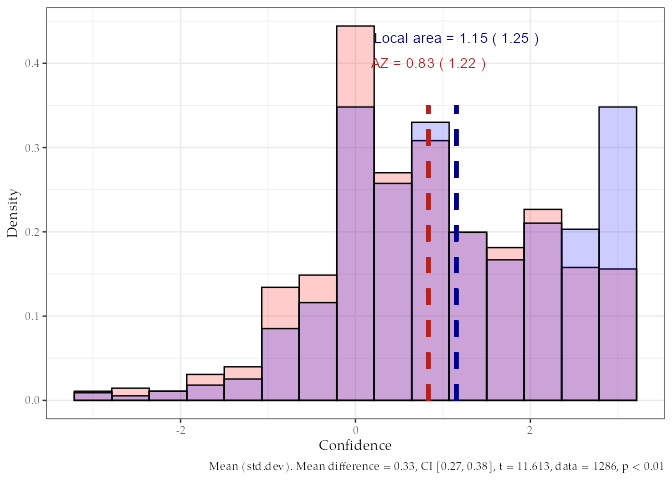
<figcaption>Figure 1: Overlapping Distribution of Confidence in Elections for AZ and Local Area</figcaption>
</figure>

Overall, the sample expressed more trust in elections relative to distrust seeing as how the distribution of confidence is largely positive. However, there’s a clear difference between confidence in Maricopa county, AZ elections and elections within one’s local area. A paired t-test confirms that this difference was statistically significant, though somewhat small (mean difference $= 0.325$, $95\%$ CI $[0.27, 0.38]$, $t(1286) = 11.61$, $p < .001$). Nonetheless, respondents appeared less confident regarding elections in Maricopa County, AZ, but held more confidence in elections administration in their local area. This complements previous research that demonstrates a similar bias favorable to one’s local area ([Stewart 2022](#ref-stewart2022)).

Accordingly, when confidence levels are distinguished by experiment condition, the treatment vignette only had an effect upon survey items pertaining to elections in Maricopa County, AZ. Conducting an independent samples t-test (i.e., Welch Two Sample t-test) suggests that the effect of the treatment compared to the control condition is positive and statistically significant.

[1] See Appendix C for Inter-item correlation analysis.

[2] The methodological concerns between the use of (unit weighted) sum or mean scores compared to the use of estimated factor scores for Likert scales composed of multiple Likert items are legion. The use of either computed sum scores or estimated factor scores as a general practice is continuously debated ([McNeish 2023](#ref-mcneish2023); [McNeish and Wolf 2020](#ref-mcneish2020); [Widaman and Revelle 2022](#ref-widaman2022), [2024](#ref-widaman2024)), yet there is no general consensus on the most appropriate method generally. The use of either appears to largely depend on the researcher’s particular research objective, theoretical suppositions, and necessity. Another common concern is the inappropriate treatment of ordinal variables as interval which levy strong assumptions, e.g., each item contributes equally to the variable being measured and that ordinal response categories are equidistant as though on an interval scale ([Wang et al. 2013](#ref-wang2013); for contrast, see [Robitzsch 2020](#ref-robitzsch2020)).

[3] This range is mostly arbitrary, as a range from -1 to 1 works much the same. When relying on simple sum total score, the scale ranges from -15 to 15. So a single point increase from 0 to 1 may reflect a combination of a single “Very confident” response on a trust item compensated by a single “Somewhat likely” response on a distrust item (i.e., 3-2 = 1), or some other equivalent combination. Although the use of mean scores would place scores back onto the response scale metric (e.g., from 0 to 3, reflective of “not at all” to “very”), this results in a unipolar scale (from 0 to 3). The bipolar scale resulting from the composition of positive trust and negative distrust engenders meaning to zero and negative values. In other words, negative values on the scale for confidence in elections hold substantive meaning (e.g., distrust, absent trust), which makes transforming scores to fit a unipolar scale inappropriate.

In [ ]:
# conduct two t-tests using `rstatix::t_test`, bind results by row, and pipe
# into table
tab_ttest <- dplyr::bind_rows(
  data |> mutate(group = forcats::fct_relevel(group, "Treatment", after = 0L)) |>
  rstatix::t_test(formula = conf.az.rescaled ~ group,var.equal = F,detailed = T),
  data |> mutate(group = forcats::fct_relevel(group, "Treatment", after = 0L)) |>
  rstatix::t_test(formula = conf.lcl.rescaled ~ group,var.equal = F, detailed = T)
  ) |> 
  # specify columns and column names
  select(
    Diff = estimate,
    treat_mean = estimate1,
    control_mean = estimate2,
    treat_n = n1,
    control_n = n2,
    t = statistic,
    p, df, conf.low, conf.high) |> 
  mutate(
    Place = dplyr::case_when(
      p <= 0.05 ~ "Maricopa County, AZ", 
      p > 0.05 ~ "Local Area"), 
    .before = Diff) |> 
  insight::format_table(stars = T)

# Output using `tinytable` R Package
colnames(tab_ttest) <- c(
  "Place",
  "$\\bar{x}_{diff}$",
  "$\\bar{x}_{treat}$",
  "$\\bar{x}_{control}$",
  "$n_{treat}$",
  "$n_{control}$",
  "t",
  "p",
  "df",
  "CI")

tinytable::tt(tab_ttest) |>
  tinytable::format_tt(
    j = 2:6, # specify columns  
    math = T # apply mathmode to specified columns
  ) |> 
  tinytable::style_tt(fontsize = 0.75) # fontsize in em units (0.75*default fontsize)
# output table as `kable` for LaTeX pdf
# kableExtra::kbl(
#   tab_ttest,
#   booktabs = T,
#   col.names = c(
#     "Place",
#     "$\\bar{x}_{diff}$",
#     "$\\bar{x}_{treat}$",
#     "$\\bar{x}_{control}$",
#     "$treat_{n}$",
#     "$control_{n}$",
#     "t",
#     "p",
#     "data",
#     "CI"
#   ),
#   escape = F
# ) |>
#   kableExtra::footnote(general = "Two Sample t-tests of difference between Confidence in Elections by Treatment Condition.") |>
#   kableExtra::kable_styling(font_size = 9, protect_latex = T)

The results of <a href="#tbl-ttest" class="quarto-xref">Table 2</a> show that, on a scale ranging from -3 to 3, the effect of the treatment is associated with a $0.20$ average difference in confidence in elections in Maricopa County, AZ, compared to the control group. When the dependent variable is centered to have a mean of $0$ and standard deviation of $1$, standardized parameters permit interpretation of the treatment effect in terms of standard deviations; the standardized difference in confidence between treatment and control is $0.16$ (CI $[0.06, 0.27]$).

In [ ]:
# coef plot of treatment effect on confidence distinguished by location
conf.coef1 <- jtools::plot_summs(
  lm(conf.az.rescaled ~ group, data = data), 
  lm(conf.lcl.rescaled ~ group, data = data), 
  center = T, scale = T, transform.response = T,
  model.names = c("Conf.AZ", "Conf.Local"),
  coefs = c("Treatment" = "groupTreatment"), 
  colors = c("red", "black"),
  point.shape = c(8, 1))+
  ggplot2::expand_limits(x = c(-0.25, 0.25))+
  labs(y = "")+
  theme_bw(base_family = "TeX Gyre Pagella")


# Coef plots of trust and distrust models for AZ and Local items
conf.coef2 <- jtools::plot_summs(
  lm(trust.scores.az ~ group, data = data),
  lm(distrust.scores.az ~ group, data = data),
  lm(trust.scores.lcl ~ group, data = data),
  lm(distrust.scores.lcl ~ group, data = data),
  center = T, scale = T, transform.response = T,
  model.names = c("Trust.AZ", "Distrust.AZ", "Trust.Local", "Distrust.Local"),
  coefs = c("Treatment" = "groupTreatment"),
  colors = c("red", "red", "black", "black"),
  point.shape = c(8, 8, 1, 1)
)+
  ggplot2::expand_limits(x = c(-0.25, 0.25))+
  labs(y = "")+
  theme_bw(base_family = "TeX Gyre Pagella")


conf.coef1
conf.coef2

<a href="#fig-coef1" class="quarto-xref">Figure 2</a> displays standard difference estimates of confidence in elections by treatment condition (control condition as reference). <a href="#fig-coef1-1" class="quarto-xref">Figure 2 (a)</a> displays two models for confidence in elections in Maricopa County, AZ, and one’s local area by treatment condition; <a href="#fig-coef1-2" class="quarto-xref">Figure 2 (b)</a> displays the same except *confidence* is decomposed into its two components, *trust* and *distrust*. These figures merely illustrate the effect of the treatment with respect to the relationship between trust and distrust; ultimately confidence improves.

Confidence in elections was higher among those who read the treatment vignette but remained conditional on whether the survey questions inquired about elections in Maricopa County, AZ. This evidence suggests that announcing efforts to recruit veterans and their families to work as election staff and volunteers may increase confidence in elections administration in places outside of one’s local area, but may not boost confidence in elections within one’s local area.

### 2020 Election Legitimacy Beliefs

I now turn to results examining the effect of the treatment on those who held onto the belief that the 2020 election results were illegitimate. First, reviewing responses to items that capture trust in elections, it is easy to recognize the difference between the way 2020 election deniers responded with respect to where elections were held.

``` python
p13.trust.treat.legit <- trust.az.treat.legit + trust.lcl.treat.legit+
  patchwork::plot_layout(guides = 'collect')

p13.trust.treat.legit
```

<figure id="fig-patch13">
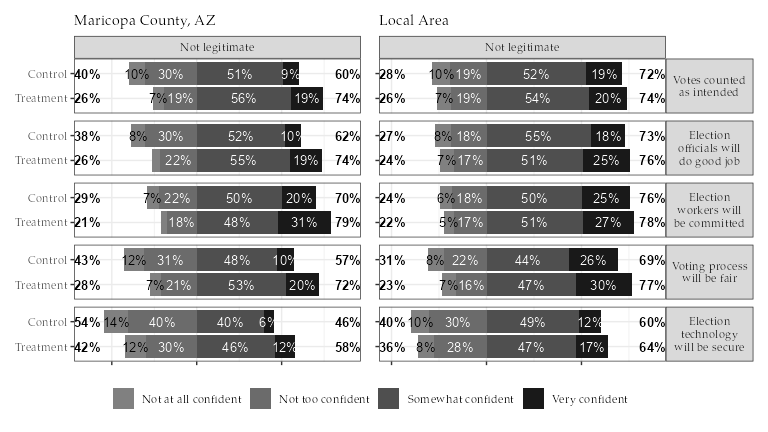
<figcaption>Figure 3: Trust in elections by treatment among those who refute the 2020 election results</figcaption>
</figure>

Among those who refuted the 2020 election results, trust in Maricopa County, AZ elections was lower for each item compared to items pertaining to elections within one’s local area, regardless of treatment condition. However, notably, trust that election technology would be secure received the lowest confidence endorsement overall. There was also a notable lack of trust that the voting process would be fair relative to the other items[1]. Now the comparative difference in responses between those in the treatment group compared to those in the control group appears substantial for items pertaining to elections in Maricopa County, AZ.

``` python
p14.distrust.treat.legit <- distrust.az.treat.legit + distrust.lcl.treat.legit+
  patchwork::plot_layout(guides = 'collect')

p14.distrust.treat.legit
```

<figure id="fig-patch14">
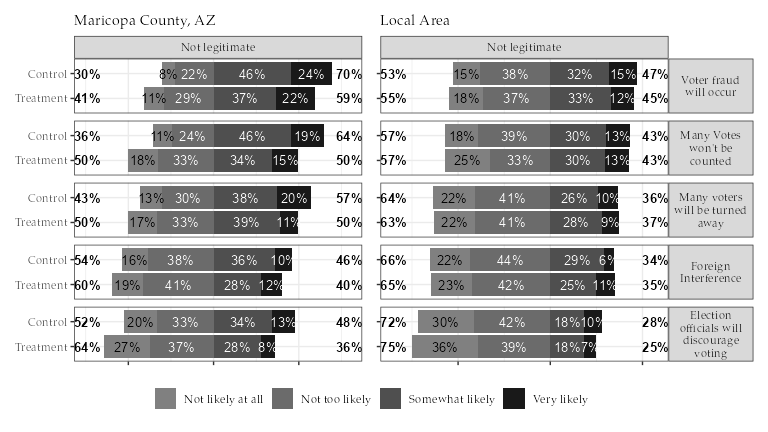
<figcaption>Figure 4: Distrust in elections by treatment among those who refute the 2020 election results</figcaption>
</figure>

Concerning distrust among those who refuted the 2020 election results, responses to items assessing one’s expectation that election fraud would occur reveal the same pattern. Although there is not as stark a disparity between responses of those in the treatment and those in the control, among those in the treatment group, there does appear to be less expectation that election fraud would occur in Maricopa County, AZ. Overall, review of responses to trust (<a href="#fig-patch13" class="quarto-xref">Figure 3</a>) and distrust survey items (<a href="#fig-patch14" class="quarto-xref">Figure 4</a>) does lend credence to the impact of the treatment.

In order to substantiate the overall influence of the treatment on confidence in elections, I regressed the dependent variable confidence on legitimacy beliefs while controlling for partisanship.

The first model in Table shows that overall confidence in elections among those who read the treatment vignette was significantly (statistically) greater than those who read the control, on average and netting out the effects of partisanship and legitimacy beliefs. Democratic partisanship remains marginally significant at $90\%$ confidence level ($p = 0.055$). Not believing the 2020 election of Joe Biden was legitimate is negatively associated with confidence in elections. In order to assess the magnitude of this interaction effect of the treatment on those who refuted the 2020 election results, I ran a model where confidence in elections was regressed on the interaction between the treatment and legitimacy beliefs, controlling for partisanship.

There’s a positive interaction effect of the treatment vignette among those who believe that the 2020 election was not legitimate, on average and controlling for partisanship. This shows that the treatment effect was most influential upon those who believe the 2020 election results were illegitimate. The treatment alone does not reverse such beliefs, but this shows where its influence was most potent.

### Concerns for Violence and Voter Safety

Thus far, publicized announcements that election officials will be targeting veterans in their recruitment efforts does quite a bit to improve confidence in elections outside of one’s local area (or, at least for elections held in Maricopa County, AZ), especially among those who believed the 2020 election results were illegitimate. While distrust is one concern during the pre-election period, it is not the only concern that arises in anticipation of US elections; the public must feel confident that voters are safe to cast a ballot in person. The survey included questions[2] that allows me to assess whether those in the treatment condition expressed less concern for violence and more confidence in voter safety compared to those in the control condition.

[1] What is interesting to note here is that the first three items regard the more human element of the election administration process, e.g., ensuring accuracy of counts, competence, and commitment of election workers. Although a neat line can’t really be drawn between the first three and latter two items presented here, it is interesting to see a slight divergence from the usual high confidence placed in local area elections.

[2] See <a href="#tbl-4" class="quarto-xref">Table 5</a> in Appendix A

``` r
# concern for violence by treatment
bar_q25 <- custom_barplot(
  data = data, 
  x = q25, 
  group = group,
  subtitle = str_wrap(attr(data$q25, "label"), width = 85)
  )+
  theme(text = element_text(family = 'TeX Gyre Pagella'),
        legend.position = "right")

# confidence in voter safety by treatment
bar_q26 <- custom_barplot(
  data = data, 
  x = q26, 
  group = group,
  subtitle = str_wrap(attr(data$q26, "label"), width = 85)
  )+
  theme(text = element_text(family = 'TeX Gyre Pagella'),
        legend.position = "right")

bar_q25
bar_q26
```

<table>
<colgroup>
<col style="width: 100%" />
</colgroup>
<tbody>
<tr>
<td style="text-align: left;"><div class="cell-output-display" width="100.0%" data-layout-align="left">
<figure id="fig-safety-bars-1">
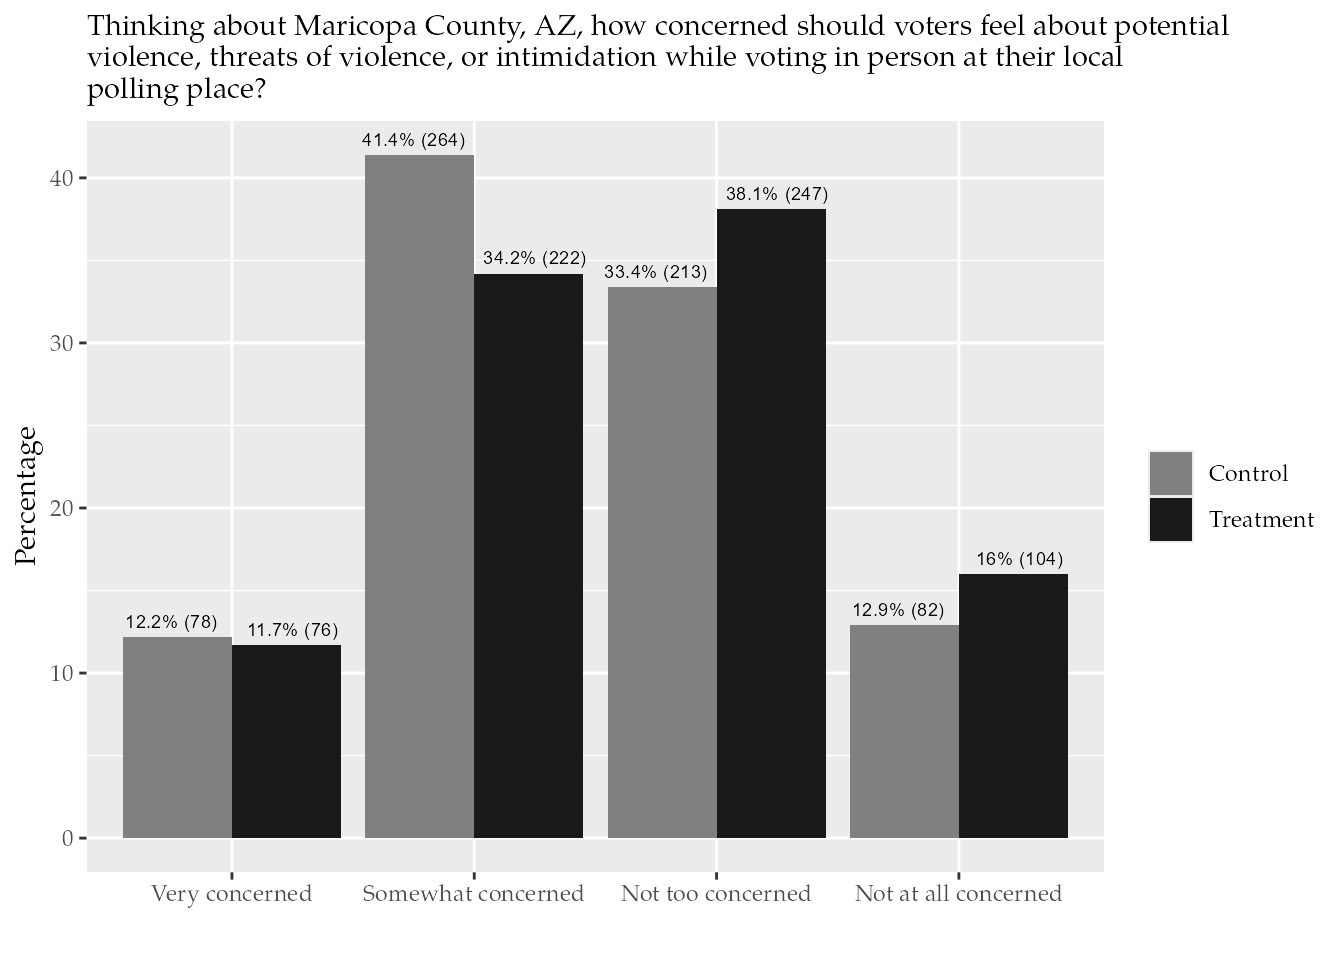
<figcaption>(a) Concern for Violence while voting in Maricopa County, AZ Elections</figcaption>
</figure>
</div></td>
</tr>
</tbody>
</table>

<table>
<colgroup>
<col style="width: 100%" />
</colgroup>
<tbody>
<tr>
<td style="text-align: left;"><div class="cell-output-display" width="100.0%" data-layout-align="left">
<figure id="fig-safety-bars-2">
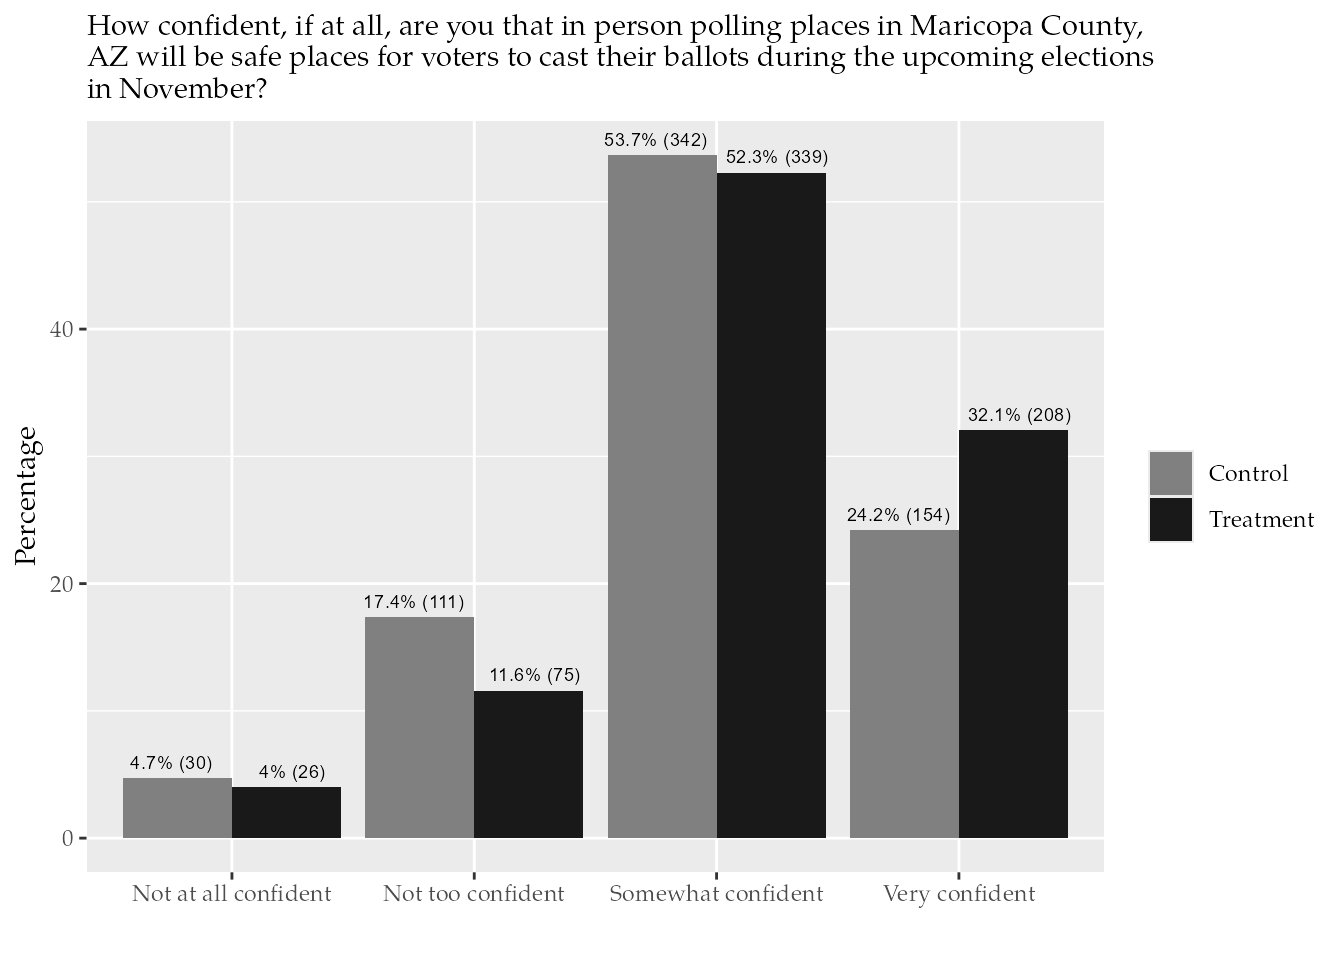
<figcaption>(b) Confidence in Voter Saftey at Election Sites in Maricopa County, AZ</figcaption>
</figure>
</div></td>
</tr>
</tbody>
</table>

Figure 5: Safety Concerns and Confidence by Treatment Condition

Briefly reviewing <a href="#fig-safety-bars" class="quarto-xref">Figure 5</a>, those in the treatment condition felt less concern over the potential for violence compared to those in the control. As for confidence in voter safety at election sites, it appears that more respondents in the treatment condition expressed that they were “Very confident” compared to those in the control, by approximately $8$ percentage points.

It would appear that the treatment vignette increased the likelihood that a respondent would select a higher response option compared to those in the control group. In order to assess whether that was the case, I conducted an ordered logistic regression on the relevant items using the experimental condition as a dichotomous predictor.

Those in the treatment condition had lower probability to express that they were ‘Very’ or ‘Somewhat’ concerned for violence in Maricopa County, AZ Elections, yet higher probability of expressing ‘Not too’ or ‘Not at all’ concerned. As for confidence in voter safety, moving from treatment to control, the difference in predicted probability of a respondent selecting “Very Confident” was $0.08$. <a href="#tbl-preds-diff1" class="quarto-xref">Table 3</a> and <a href="#tbl-preds-diff2" class="quarto-xref">Table 4</a> show the significant differences in predicted probabilities at 95$\%$ confidence[1].

[1] The same models were run for items pertaining to safety concerns in one’s local area but results of the treatment were not significantly different from the control. See Appendix D for full results table of ordinal logistic regression

In [ ]:
# needed to duplicate `group` variable with different column name due to
# conflict with marginaleffects R package
data <- data |>
  mutate(condition = group)

# running ordinal logisitc regression models (proportional odds logistic regression)
m.q25 <- MASS::polr(q25 ~ condition, data = data, method = "logistic", Hess = T)
m.q26 <- MASS::polr(q26 ~ condition, data = data, method = "logistic", Hess = T)
m.q36 <- MASS::polr(q36 ~ condition, data = data, method = "logistic", Hess = T)
m.q37 <- MASS::polr(q37 ~ condition, data = data, method = "logistic", Hess = T)

# "Outcome predicted by a fitted model on a specified scale for a given
# combination of values of the predictor variables, such as their observed
# values, their means, or factor levels (a.k.a. "reference grid")".

# predictions(): unit-level (conditional) estimates.

# predicted probability estimates by treatment or control
q25_preds <- marginaleffects::predictions(m.q25, by = "condition", type = "probs")
q26_preds <- marginaleffects::predictions(m.q26, by = "condition", type = "probs")
q36_preds <- marginaleffects::predictions(m.q36, by = "condition", type = "probs")
q37_preds <- marginaleffects::predictions(m.q37, by = "condition", type = "probs")

# this provides the difference in predicted probabilities between treatment and
# control
pdiff_q25 <- marginaleffects::predictions(
  m.q25,
  by = "condition",
  type = "probs",
  hypothesis = ~ reference | group
)

pdiff_q26 <- marginaleffects::predictions(
  m.q26,
  by = "condition",
  type = "probs",
  hypothesis = ~ reference | group
)

In [ ]:
tab_q25_pdiff <- pdiff_q25 |>
  dplyr::as_tibble() |>
  dplyr::rename(
    Violence = group,
    z = statistic,
    'Pr(>|z|)' = p.value) |>
  select(Violence,
         hypothesis,
         estimate,
         std.error,
         z,
         'Pr(>|z|)',
         conf.low,
         conf.high) |>
  insight::format_table(stars = T, digits = 3)

tinytable::tt(
  tab_q25_pdiff, 
  notes = "Results derived from proportional odds logistic regression model. Estimates are differences in predicted probabilities transformed from log odds ratios, and represent difference in estimated prediction of choosing a particular response or higher") |> 
  tinytable::style_tt(
    fontsize = 0.80 # fontsize of text in table in em units (0.75*default)
    ) |>  
  tinytable::style_tt(i = "notes", fontsize = 0.75)
  # kableExtra::kbl(tab_q25_pdiff, 
  #                 booktabs = T) |> 
  # kableExtra::footnote(general = "Results derived from proportional odds logistic regression model. Estimates are differences in predicted probabilities transformed from log odds ratios, and represent difference in estimated prediction of choosing a particular response or higher")

In [ ]:
tab_q26_pdiff <- pdiff_q26 |>
  dplyr::as_tibble() |>
  dplyr::rename('Voter Safety' = group,
                z = statistic,
                'Pr(>|z|)' = p.value) |>
  select('Voter Safety',
         hypothesis,
         estimate,
         std.error,
         z,
         'Pr(>|z|)',
         conf.low,
         conf.high) |>
  insight::format_table(stars = T, digits = 4)

tinytable::tt(
  tab_q26_pdiff, 
  notes = "Results derived from proportional odds logistic regression model. Estimates are differences in predicted probabilities transformed from log odds ratios, and represent difference in estimated prediction of choosing a particular response or higher") |>  
  tinytable::style_tt(
    fontsize = 0.80 # fontsize of text in table in em units (0.75*default)
    ) |>  
  tinytable::style_tt(i = "notes", fontsize = 0.75) # style font of table notes
  # kableExtra::kbl(tab_q26_pdiff, 
  #                 booktabs = T) |> 
  # kableExtra::footnote(general = "Results derived from proportional odds logistic regression model. Estimates are differences in predicted probabitilites transformed from log odds ratios, and represent difference in estimated prediction of choosing a particular response or higher")

## Conclusion

Publicized announcements that election officials are actively recruiting former military service members to work as election staff and volunteers is associated with greater confidence in elections compared to election worker recruitment announcements that do not explicitly mention targeted efforts to recruit former military service members. In addition, such public announcements eased concerns about violence and increased confidence that voters would be safe to vote in person at election sites. Of course, the higher levels of confidence in elections and voter safety observed among the treatment group were limited to considerations about elections held in Maricopa County, AZ—presumably beyond one’s local area. This is to be expected bearing in mind that confidence in elections for one’s local area is usually higher than for those beyond. Thus, there’s already more insecurity concerning elections elsewhere for whatever reason.

One obvious contribution of these results shows that the perceived trustworthiness of elections administration is amendable to generalized impressions about the kind and character of the people who work and volunteer as election staff. Whatever election officials do to boost public confidence may be overshadowed by impressions about who is staffing election sites.

It should be noted that these results are limited to one’s expectations in anticipation of election night. Whether the increase in confidence is sustained post-election night cannot be inferred from these results. Moreover, It is yet unclear whether actually encountering and interacting with veterans working as staff or volunteers at election sites does much to improve voter confidence after election night compared to anyone else. It may be the case that assumptions that veterans are filling spots as election workers and volunteers simply primes positive expectations as one heads into an election site, potentially improving voters perceptions of their own experience on the way out. Further research would be needed to test such an idea.

In general, public confidence appears strongest when the elections under consideration regard those within one’s local community. Yet, such strong confidence is not generalized outward to the institution of elections administration as a whole. Insecurity in the integrity of the electoral process and its administration may be naturally higher for elections that occur further from home. Whether that is due to some local favorability bias or some outward negativity bias is hard to say. And seeing as how insecurity presents vulnerability, it is perhaps far easier to inspire a general sense of distrust in the process and its administration in places more abstract.

In the anticipatory period prior to national elections, publicized efforts to recruit veterans to work as election staff and volunteers may be a small, but positive, step towards reducing insecurity in elections that occur elsewhere. Especially among those who maintained a steadfast degree of distrust in elections. Despite a lack of evidence that systematic electoral fraud had occurred in the 2020 election, a substantial proportion of the population were unwilling to affirm the legitimacy of the results. However, despite such legitimacy beliefs, most were not consistent as they expressed varying levels of trust in different aspects of elections administration. These results say more about the influence that military veterans have among those who are most insecure than it does about the public more generally.



# Appendix A: Survey Experiment Vignettes and Survey Items

## Survey Experiment Vignettes

In [ ]:
var_label_tab <- function(x){
    purrr::map(x, ~attr(., "label")) |>
    purrr::map(~ifelse(purrr::is_null(.), "No label", .)) |>
    tibble::enframe(name = "var", value = "var_label") |>
    tidyr::unnest(cols = c(var_label))
}


Questions <- data |> 
  dplyr::select(q7, q25, q26, q36, q37) |>
  dplyr::rename_with(.cols = everything(), .fn = ~snakecase::to_any_case(.,case = "upper_camel")) |> 
  var_label_tab() |>
  dplyr::select(Question = var_label) |> 
  dplyr::pull(Question)

items_responses <- data.frame(
  Questions = Questions,
  Response =c(
    "- Legitimate\n- Not legitimate",
    "- Very concerned\n- Somewhat concerned\n- Not too concerned\n- Not at all concerned",
    "- Not at all confident\n- Not too confident\n- Somewhat confident\n- Very confident",
    "- Very concerned\n- Somewhat concerned\n- Somewhat unconcerned\n- Not at all concerned",
    "- Not at all confident\n- Not too confident\n- Somewhat confident\n- Very confident")
)
  
  
# wrap in a minipage environment
minipagify <- function(x) {
  sprintf(
    "\\minipage{\\textwidth}%s\\endminipage",
    sapply(x, mark, "latex")
  )
}

# only in LaTeX
is_latex <- identical(knitr::pandoc_to(), "latex")

tab <- tinytable::tt(items_responses, width = c(0.7, 0.3)) |>
  tinytable::style_tt(j = c(1,2), fontsize = 0.8, align = "l") |>
  tinytable::format_tt(markdown = TRUE) |>
  tinytable::format_tt(j = 2, fn = if (is_latex) minipagify else NULL)

tab
# 
# Response <- data |> 
#   dplyr::select(q7, q25, q26, q36, q37) |>
#   surveytoolbox::data_dict() |> 
#   dplyr::as_tibble() |> 
#   dplyr::select(value)
# 
# 
# item_table <- data |> 
#   select(q7, q25, q26, q36, q37) |>
#   dplyr::rename_with(.cols = everything(), .fn = ~snakecase::to_any_case(.,case = "upper_camel")) |> 
#   var_label_tab() |>
#   select(Question = var_label) |> 
#   mutate(Response = Response$value)
# 
# item_table
# 
# tinytable::tt(item_table, width = c(.7, .3)) |> 
#   tinytable::style_tt(fontsize = 0.80)

# alternate
# kableExtra::kbl(item_table, booktabs = T, linesep = "\\addlinespace[2mm]") |> 
#   kableExtra::kable_styling(
#     full_width = T,
#     font_size = 9,
#     latex_options = c("HOLD_position")
#     ) |> 
#   kableExtra::pack_rows(index = c("Legitimacy" = 1,
#                                   "Safety Concerns" = 4))

# Appendix B: Sample Demographics and Balance

## Sample Demographics

The median age was 46 (mean age was $47$), $51.7\%$ ($n = 658$) women, $47\%$ ($n = 598$) men, and approximately $1.3\%$ who identified as either Non-binary/third gender ($n = 7$) or preferred not to say ($n = 9$). A large proportion of the sample identified as White or Caucasian ($n = 975, 76.65\%$), while all other non-White respondents comprised $27.83\%$ ($n = 297$) of the sample. Those who held a graduate level degree (e.g., Master’s, Doctorate, or Professional level) comprised $13\%$ of the sample; those with either degree at the Associate or Bachelor’s level comprised $36.24\%$, while $22.25\%$ had some college but no degree; and $28.46\%$ had either a high school level or equivalent education or less than high school. The largest proportion of the sample identified as Democrat at $44.64\%$, followed by Republicans at $42.59\%$. The proportion of true Independents[1] was $12.78\%$.

[1] Independent ‘leaners’ were grouped into the respective party affiliation in which they lean.

In [ ]:
# descriptive stats of categorical variables
# best method for html document
tbl.desc <- data |>  
  labelled::set_variable_labels(
    age_4cat = "Age group",
    gender_3cat = "Gender",
    race2 = "Race/Ethnicity",
    race_wnw = "White or Non-White",
    educ_4cat = "Education",
    partyid_3cat = "Party ID",
    milrelation  = "Military Relation"
  ) |> 
  gtsummary::tbl_summary(
    by = group,
    include = c(
    age_4cat, 
    gender_3cat, 
    race2,
    race_wnw,
    educ_4cat, 
    partyid_3cat,
    milrelation),
    statistic = list(gtsummary::all_categorical()~ "{n} ({p}%)"), 
    missing = "ifany",
    missing_text = "NA") |> 
  gtsummary::add_n() |> 
  gtsummary::add_overall() |> 
  gtsummary::modify_header(label = "**Demographic**") |> 
  gtsummary::bold_labels()

gtsummary::as_kable_extra(tbl.desc, booktabs = T) |>
  kableExtra::add_footnote(
    label = "Independents do not identify nor 'lean' toward either political party") |> 
  kableExtra::kable_styling(
    font_size = 9, 
    protect_latex = T)
# gtsummary::as_gt(tbl.desc) |>  
#   gt::tab_footnote(
#     footnote = "Independents do not identify nor 'lean' toward either political party",
#     placement = "left"
#     ) |>  
#   gt::cols_align(align = 'left', columns = everything()) |> 
#   gt::tab_options(
#     table.font.size = "small",
#     data_row.padding = gt::px(1)
#   )

## Test of Random Assignment to Experiment Condition

<a href="#tbl-logit" class="quarto-xref">Table 7</a> shows results of a logistic regression test of random assignment to the treatment group. Demographics such as age, gender, race, educational attainment, and party ID are included as predictor variables. Note that 19 missing observations were deleted. A $\chi^2 = 11.010$, with 15 degrees of freedom and associated p-value \> 0.05 ($p = 0.75$) confirms that none of the demographic predictor variables significantly increased the log-odds—in turn, the probability—of being assigned to the treatment group.

In [ ]:
# simple logit of test of random assignment to treatment
# treatment is DV (treatment = 1, control = 0)
# demographic variables are IVs
m1 <- glm(group ~ age_4cat + gender_3cat + race2 + educ_4cat + partyid_3cat, 
          family = binomial(link = "logit"), data = data)


# use `gtsummary` package to build regression table, then output as tibble
logit_tab <- gtsummary::tbl_regression(
    m1,
    intercept = F,
    label = list(
      age_4cat ~"Age",
      gender_3cat ~ "Gender",
      race2 ~ "Race/Ethnicity",
      educ_4cat ~ "Education",
      partyid_3cat ~ "Party ID")) |>
  gtsummary::bold_labels() |>
  # gtsummary::show_header_names()
  gtsummary::modify_header(
    label = " ",
    stat_nevent = "**Treatment N**") |>
  # output as_tibble
  gtsummary::as_tibble() |>
  # omit p.values
  dplyr::select(-4)

# transform tibble dataframe into `tinytable` and format as markdown
# replace NA with blank " " (or "-" if desired)
logit_tab <- tinytable::tt(logit_tab, width = 0.8) |> 
  tinytable::format_tt(markdown = T) |> 
  tinytable::format_tt(replace = " ")

# create 2nd table containing only logit model fit statistics
# using custom function, get logit regression model fit stats... 
gof_stats <- lrm.gof.stats(m1) |> 
  # omit certain stats (saves space)
  dplyr::select(
    nobs, logLik, df, chisq, P..chi., deviance, null.deviance,
    -AIC, -BIC, -df.null, -df.residual) |> 
  # rename column variables
  dplyr::rename(
    "Num.Obs"       = "nobs",
    "Null Deviance" = "null.deviance",
    "Deviance"      = "deviance",
    "DF"            = "df",
    "Log.Lik"       = "logLik",
    "\\chi^2"       = "chisq",
    "P(>\\chi^2)"   = "P..chi."
  ) |> 
  # pivot into two column long-form dataframe
  tidyr::pivot_longer(cols = everything(),names_to = " ", values_to = '**log(OR)**') |>
  # pipe into tinytable
  tinytable::tt(width = 0.8) |> 
  # ensure rows with math text are identified and formatted as math (i.e., $..$)
  tinytable::format_tt(i = c(4,5), j = 1, math = T)
  
# using `rbind2` function, bind 2nd table at bottom of first table 
tinytable::rbind2(logit_tab, gof_stats, use_names = F, headers = F) |> 
  # add horizontal line just above fit stats
  tinytable::style_tt(i = 26, line = "t", line_color = "black", line_width = 0.1) |>
  # adjust fontsize of text within table
  tinytable::style_tt(fontsize = 0.8) |>
  # finally, format markdown and blank out any NA fillers
  tinytable::format_tt(markdown = T, replace = " ")



# Appendix C: Polychoric Item and Score Correlations of Trust and Distrust

## Trust and Distrust

Polychoric correlation is a measure of association between two ordered categorical variables each assumed to represent (i.e., indicate, be influenced by) two normally distributed, continuous, latent variables. Due to the fact that each item is an ordered categorical variable assumed to represent one of two latent constructs (i.e., trust or distrust, respectively), I examined polychoric correlations between the items used to construct each scale. In addition, one set of the trust and distrust items pertained to Maricopa County, AZ, whereas the other set of items were identical except that these items pertained to one’s local area.

Since the two sets of items (AZ items and Local items) are, in theory, supposed to capture the same normally distributed continuous latent variables, then the polychoric inter-item correlations should be significantly associated, strong, and in the same direction for the items that measure trust regardless of whether the items pertain to AZ or one’s local area (likewise for distrust). Simply, trust/distrust in elections in AZ should strongly and positively be associated with trust/distrust in elections in one’s local area.

Additionally, the items that indicate trust should negatively correlate with items that indicate distrust. Furthermore, the strength of the negative correlations between trust and distrust should closely approximate if not match.

In [ ]:
# Get polychoric item correlation matrix.
item.cor <- data |>
  select(q19:q24, -q23, q28_1:q28_5, q30:q35, -q34, q40_1:q40_5) |> 
  # ensure factors are ordered factors
  mutate(across(where(is.factor), ~factor(., ordered = T))) |> 
  # adjust variable column names of items
  dplyr::rename(
    trustvote_az     = q19,
    trustadmin_az    = q20,
    truststaff_az    = q21,
    trustprcss_az    = q22,
    trusttech_az     = q24,
    votefraud_az     = q28_1,
    miscount_az      = q28_2,
    turnedaway_az    = q28_3,
    foreigntamp_az   = q28_4,
    discourage_az    = q28_5,
    trustvote_lcl    = q30,
    trustadmin_lcl   = q31,
    truststaff_lcl   = q32,
    trustprcss_lcl   = q33,
    trusttech_lcl    = q35,
    votefraud_lcl    = q40_1,
    miscount_lcl     = q40_2,
    turnedaway_lcl   = q40_3,
    foreigntamp_lcl  = q40_4,
    discourage_lcl   = q40_5
  ) |> 
  correlation::correlation(
    select = 
      c("trustvote_az", "trustadmin_az", "truststaff_az", "trustprcss_az", "trusttech_az",
        "votefraud_az", "miscount_az", "turnedaway_az", "foreigntamp_az", "discourage_az"),
    select2 =
      c("trustvote_lcl", "trustadmin_lcl", "truststaff_lcl", "trustprcss_lcl","trusttech_lcl",
        "votefraud_lcl", "miscount_lcl", "turnedaway_lcl", "foreigntamp_lcl","discourage_lcl"),
    method = "polychoric") |>
  summary()

# plot item correlations
plot(item.cor) + theme(axis.text.x = element_text(angle = 45, vjust = 0.6))

Indeed, this is what is revealed by the correlation matrix (<a href="#fig-polycor" class="quarto-xref">Figure 7</a>). Trust items correlate positively, strongly, and are significant regardless of location at which the items pertain. The same goes for distrust items. Also, items meant to measure trust negatively correlate with the items that measure distrust. However, the positive correlations are not nearly as high as would be expected supposing that the items are nearly identical theoretical indicators of the same hypothetical constructs, i.e., trust and distrust respectively.

If the items accurately measure trust/distrust in elections regardless of where those elections are said to take place, then positive correlations between the AZ and Local area items should approach perfect correlation as though the same exact questions were asked twice. This result, however, suggests that the location of which the survey items pertain (and perhaps other factors) makes a substantial difference in the pattern of responses, but also raises valid questions as to whether the items accurately measure the latent variable constructs in the first place.

Although I do not explicitly assume that the survey instruments perfectly measure the hypothetical constructs of interest (i.e., trust and distrust), perfect measurement is implicitly assumed by the method of combining multiple item responses into a sum or mean composite score.

In short, I expected item responses from the trust and distrust scales to be inversely correlated among the sample, but not mutually exclusive. Indeed, this is what I find. Polychoric correlations between the trust and distrust items negatively correlate as expected, as does the correlation between the two sum score scales. Given the ordinal nature of the variable items, I conducted a Spearman’s rank correlation test ([Spearman 1907](#ref-spearman1907)) and found a negative correlation of $\rho = -0.49$ ($95\%$ CI \[-0.53, -0.44\]; Kendall’s $\tau = -0.39$) between scores on the two scales for the AZ items (For the local item scale score correlation: $\rho = -0.52$, $95\%$ CI \[-0.56, -0.48\]; Kendall’s $\tau = -0.39$). The negative correlation between the trust and distrust items and scores makes intuitive sense.



# Appendix D: Predicted Probabilities of Safety Concerns by Treatment Condition

In [ ]:
# save models to a list
safety_models <- list(
  "Concerns for Violence (OR)" = m.q25,
  "Confidence in Voter Safety (OR)" = m.q26)

cm <- c("conditionTreatment" = "Treatment",
        "Very concerned|Somewhat concerned" = "Very concerned | Somewhat concerned",
        "Somewhat concerned|Not too concerned" = "Somewhat concerned | Not too concerned",
        "Not too concerned|Not at all concerned" = "Not too concerned | Not at all concerned",
        "Not at all confident|Not too confident" = "Not at all confident | Not too confident",
        "Not too confident|Somewhat confident" = "Not too confident | Somewhat confident",
        "Somewhat confident|Very confident" = "Somewhat confident | Very confident"
        )

tbl_safety_logit <- modelsummary::modelsummary(
  safety_models,  
  fmt = 3,
  output = "tinytable",
  exponentiate = T, # show odds ratio 
  # coef_omit = c(-4), # only the beta coef, not the intercepts
  # coef_rename = c("conditionTreatment" = "Treatment"),
  coef_map = cm,
  stars = T,
  # estimate = c("{estimate}{stars}"),
  statistic = "conf.int",
  gof_map = c("nobs", "rmse"), 
  note = list(
    "Parameter estimate (and confidence intervals) exponentiated to show odds ratios.",
    "Uncertainty intervals (profile-likelihood) and p-values (two-tailed) computed using a Wald t-distribution approximation")
  )

tbl_safety_logit |>  
  tinytable::style_tt(
    fontsize = 0.80 # fontsize of text in table in em units (0.75*default)
    ) |> 
  tinytable::style_tt(i = "notes", fontsize = 0.75)

In [ ]:
# table that shows the predicted probability of selecting a response or lower
# conditional to the Treatment experiment condition.
tab_safety_preds1 <- q25_preds |>  
  dplyr::as_tibble() |> 
  select(group, condition, 
         estimate, std.error, statistic,  p.value,
         conf.low, conf.high) |> 
  dplyr::rename(
    Condition = condition,
    Violence = group,
    z = statistic,
    'Pr(>|z|)' = p.value) |>
  insight::format_table(digits = 3)


tinytable::tt(
  tab_safety_preds1, digits = 3,
  notes = attr(data$q25, "label")) |> 
  tinytable::style_tt(
    fontsize = 0.80 # fontsize of text in table in em units (0.75*default)
    ) |> 
  tinytable::style_tt(i = "notes", fontsize = 0.75)

In [ ]:
# table that shows the predicted probability of selecting a response or lower
# conditional to the Treatment experiment condition.
tab_safety_preds2 <- q26_preds |> 
  dplyr::as_tibble() |> 
  select(group, condition, 
         estimate, std.error, statistic,  p.value,
         conf.low, conf.high) |> 
  dplyr::rename(
    Condition = condition,
    'Voter Safety' = group,
    z = statistic,
    'Pr(>|z|)' = p.value) |>
  insight::format_table(digits = 3)

tinytable::tt(
  tab_safety_preds2, digits = 3,
  notes = attr(data$q26, "label")) |>  
  tinytable::style_tt(
    fontsize = 0.80 # fontsize of text in table in em units (0.75*default)
    ) |> 
  tinytable::style_tt(i = "notes", fontsize = 0.75)



# References

Abbate, Andrea. 2020. “39 Ways Election Offices Are Responding to COVID-19.” <https://www.techandciviclife.org/covid-19-responses/>.

Atkeson, Lonna Rae, and Kyle L. Saunders. 2007. “The Effect of Election Administration on Voter Confidence: A Local Matter?” *PS: Political Science & Politics* 40(4): 655–60. doi:[10.1017/S1049096507071041](https://doi.org/10.1017/S1049096507071041).

Bowler, Shaun, and Todd Donovan. 2024. “Confidence in US Elections After the Big Lie.” *Political Research Quarterly* 77(1): 283–96. doi:[10.1177/10659129231206179](https://doi.org/10.1177/10659129231206179).

Brennan Center for Justice. 2024. *Local Election Officials Survey — May 2024 Brennan Center for Justice*. Brennan Center Research Department. <https://www.brennancenter.org/our-work/research-reports/local-election-officials-survey-may-2024> (November 5, 2024).

Carter, Luke, Ashlan Gruwell, J Quin Monson, and Kelly D Patterson. 2024. “From Confidence to Convenience: Changes in Voting Systems, Donald Trump, and Voter Confidence.” *Public Opinion Quarterly* 88: 516–35. doi:[10.1093/poq/nfae034](https://doi.org/10.1093/poq/nfae034).

Cikara, Mina, and Jay J Van Bavel. 2014. “The Neuroscience of Intergroup Relations.” *Perspectives on Psychological Science* 9(3): 245–74.

Claassen, Ryan L., David B. Magleby, J. Quin Monson, and Kelly D. Patterson. 2008. “‘At Your Service’: Voter Evaluations of Poll Worker Performance.” *American Politics Research* 36(4): 612–34. doi:[10.1177/1532673X08319006](https://doi.org/10.1177/1532673X08319006).

Coll, Joseph A, and Christopher J Clark. 2024. “A Racial Model of Electoral Reform: The Relationship Between Restrictive Voting Policies and Voter Confidence for Black and White Voters.” *Public Opinion Quarterly* 88: 561–84. doi:[10.1093/poq/nfae032](https://doi.org/10.1093/poq/nfae032).

Conde, Ximena. 2020. “Philly Area Counties Say Efforts to Recruit Poll Workers for Election Day Are Paying Off.” *WHYY NPR*. <https://whyy.org/articles/philly-area-counties-say-efforts-to-recruit-poll-workers-for-election-day-are-paying-off/>.

Cooter, Amy. 2013. “Americanness, Masculinity, and Whiteness: How Michigan Militia Men Navigate Evolving Social Norms.” Thesis. <http://deepblue.lib.umich.edu/handle/2027.42/98077>.

Cooter, Amy. 2024. “Veterans and Extremism: From Militias to January 6th and Real Patriots Middlebury Institute of International Studies at Monterey.” <https://www.middlebury.edu/institute/academics/centers-initiatives/ctec/ctec-publications/veterans-and-extremism-militias-january-6th>.

Corrigan, Patrick W., David Rowan, Amy Green, Robert Lundin, Philip River, Kyle Uphoff-Wasowski, Kurt White, and Mary Anne Kubiak. 2002. “Challenging Two Mental Illness Stigmas: Personal Responsibility and Dangerousness.” *Schizophrenia Bulletin* 28(2): 293–309. doi:[10.1093/oxfordjournals.schbul.a006939](https://doi.org/10.1093/oxfordjournals.schbul.a006939).

Daniller, Andrew M, and Diana C Mutz. 2019. “The Dynamics of Electoral Integrity: A Three-Election Panel Study.” *Public Opinion Quarterly* 83(1): 46–67. doi:[10.1093/poq/nfz002](https://doi.org/10.1093/poq/nfz002).

Doubek, James. 2024. “States and Cities Beef up Security to Prepare for Potential Election-Related Violence.” *NPR: 2024 Election*. <https://www.npr.org/2024/11/04/nx-s1-5178083/national-guard-police-election-security> (November 5, 2024).

Dunn, Amina. 2018. “Elections in America: Concerns Over Security, Divisions Over Expanding Access to Voting.” <https://www.pewresearch.org/politics/2018/10/29/elections-in-america-concerns-over-security-divisions-over-expanding-access-to-voting/>.

Edlin, Ruby, and Lawrence Norden. 2024. “Poll of Election Officials Finds Concerns About Safety, Political Interference Brennan Center for Justice.” <https://www.brennancenter.org/our-work/analysis-opinion/poll-election-officials-finds-concerns-about-safety-political>.

Ferrer, Joshua, Daniel M Thompson, and Rachel Orey. 2024. *Election Official Turnover Rates from 2000–2024*. Bipartisan Policy Center. <https://bipartisanpolicy.org/download/?file=/wp-content/uploads/2024/04/WEB_BPC_Elections_Admin_Turnover_R01.pdf>.

Giles, Ben. 2021. “Arizona Recount Of 2020 Election Ballots Found No Proof Of Corruption.” *NPR: 2024 Election*. <https://www.npr.org/2021/09/25/1040672550/az-audit>.

Hall, Thad E., J. Quin Monson, and Kelly D. Patterson. 2009. “The Human Dimension of Elections: How Poll Workers Shape Public Confidence in Elections.” *Political Research Quarterly* 62(3): 507–22. doi:[10.1177/1065912908324870](https://doi.org/10.1177/1065912908324870).

Hall, Thad, J. Quin Monson, and Kelly D. Patterson. 2007. “Poll Workers and the Vitality of Democracy: An Early Assessment.” *PS: Political Science & Politics* 40(4): 647–54. doi:[10.1017/S104909650707103X](https://doi.org/10.1017/S104909650707103X).

Hardy, Molly M., Calvin R. Coker, Michelle E. Funk, and Benjamin R. Warner. 2019. “Which Ingroup, When? Effects of Gender, Partisanship, Veteran Status, and Evaluator Identities on Candidate Evaluations.” *Communication Quarterly* 67(2): 199–220. doi:[10.1080/01463373.2019.1573201](https://doi.org/10.1080/01463373.2019.1573201).

Herndon, Astead W. 2020. “LeBron James and a Multimillion-Dollar Push for More Poll Workers.” *The New York Times: U.S.* <https://www.nytimes.com/2020/08/24/us/politics/lebron-james-poll-workers.html> (November 13, 2024).

Herrnson, Paul S., Richard G. Niemi, and Michael J. Hanmer. 2009. *Voting Technology : The Not-so-Simple Act of Casting a Ballot*. Washington, D.C: Brookings Institution Press.

Hipes, Crosby, Jeffrey Lucas, Jo C. Phelan, and Richard C. White. 2016. “The Stigma of Mental Illness in the Labor Market.” *Social Science Research* 56: 16–25. doi:[10.1016/j.ssresearch.2015.12.001](https://doi.org/10.1016/j.ssresearch.2015.12.001).

Hooghe, Marc. 2018. “Trust and Elections.” In *The Oxford Handbook of Social and Political Trust*, ed. Eric M. Uslaner. Oxford University Press, 0. doi:[10.1093/oxfordhb/9780190274801.013.17](https://doi.org/10.1093/oxfordhb/9780190274801.013.17).

Jensen, Michael, Elizabeth Yates, and Sheehan Kane. 2022. *Radicalization in the Ranks: An Assessment of the Scope and Nature of Criminal Extremism in the United States Military*. National Consortium for the Study of Terrorism and Responses to Terrorism (START): College Park. <https://www.start.umd.edu/pubs/Radicalization%20in%20the%20Ranks_April%202022.pdf>.

Kleykamp, Meredith, and Crosby Hipes. 2015. “Coverage of Veterans of the Wars in Iraq and Afghanistan in the U.S. Media.” *Sociological Forum* 30(2): 348–68. doi:[10.1111/socf.12166](https://doi.org/10.1111/socf.12166).

Kleykamp, Meredith, Daniel Schwam, and Gilad Wenig. 2023. *What Americans Think About Veterans and Military Service: Findings from a Nationally Representative Survey*. RAND Corporation. <https://www.rand.org/pubs/research_reports/RRA1363-7.html>.

Levendusky, Matthew, Shawn Patterson Jr., Michele Margolis, Yotam Ophir, Dror Walter, and Kathleen Hall Jamieson. 2024. “The Long Shadow of the Big Lie: How Beliefs about the Legitimacy of the 2020 Election Spill Over onto Future Elections.” *Public Opinion Quarterly*: nfae047. doi:[10.1093/poq/nfae047](https://doi.org/10.1093/poq/nfae047).

Lincoln, Sophie. 2024. “Washoe County Staff Prepare for Election Day, Announce New Safety Feature at Polls.” <https://mynews4.com/news/local/washoe-county-staff-prepare-for-election-day-announce-new-safety-feature-at-polls> (November 5, 2024).

Loewenson, Irene. 2023. “Mattis Says Vets at Jan. 6 Capitol Riot ‘Don’t Define the Military’.” *Marine Corps Times: name*. <https://www.marinecorpstimes.com/news/your-marine-corps/2023/11/06/mattis-says-vets-at-jan-6-capitol-riot-dont-define-the-military/>.

MacLean, Alair, and Meredith Kleykamp. 2014. “Coming Home: Attitudes Toward U.S. Veterans Returning from Iraq.” *Social Problems* 61(1): 131–54. doi:[10.1525/sp.2013.12074](https://doi.org/10.1525/sp.2013.12074).

Magni, Gabriele, and Andrew Reynolds. 2024. “Candidate Identity and Campaign Priming: Analyzing Voter Support for Pete Buttigieg’s Presidential Run as an Openly Gay Man.” *Political Research Quarterly* 77(1): 184–98. doi:[10.1177/10659129231194325](https://doi.org/10.1177/10659129231194325).

Maidenberg, David H. 1996. *Recruiting Poll Workers*. Office of Election Administration, Federal Election Commission. <https://purl.fdlp.gov/GPO/gpo18585>.

Maricopa County Elections Department. 2022. *Correcting the Record: Maricopa County’s In-Depth Analysis of the Senate Inquiry*. Maricopa County, Arizona: Maricopa County Elections Department and Office of the Recorder. <https://elections.maricopa.gov/asset/jcr:a9e03750-0a8f-4162-859f-1d46ac54b485/Correcting%20The%20Record%20-%20January%202022%20Report.pdf>.

McNeish, Daniel. 2023. “Psychometric Properties of Sum Scores and Factor Scores Differ Even When Their Correlation Is 0.98: A Response to Widaman and Revelle.” *Behavior Research Methods* 55(8): 4269–90. doi:[10.3758/s13428-022-02016-x](https://doi.org/10.3758/s13428-022-02016-x).

McNeish, Daniel, and Melissa Gordon Wolf. 2020. “Thinking Twice about Sum Scores.” *Behavior Research Methods* 52(6): 2287–2305. doi:[10.3758/s13428-020-01398-0](https://doi.org/10.3758/s13428-020-01398-0).

Mena, Kelly. 2020. “States Scramble to Recruit Thousands of Poll Workers Amid Pandemic Shortage CNN Politics.” <https://www.cnn.com/2020/08/13/politics/poll-worker-shortage-2020-election/index.html>.

Milton, Daniel, and Andrew Mines. 2021. *“This Is War:” Examining Military Experience Among the Capitol Hill Siege Participants*. George Washington University. doi:[10.4079/poe.04.2021.00](https://doi.org/10.4079/poe.04.2021.00).

Nadeau, Richard, and André Blais. 1993. “Accepting the Election Outcome: The Effect of Participation on Losers’ Consent.” *British Journal of Political Science* 23(4): 553–63. doi:[10.1017/S0007123400006736](https://doi.org/10.1017/S0007123400006736).

Nadeem, Reem. 2024. “Harris, Trump Voters Differ Over Election Security, Vote Counts and Hacking Concerns.” <https://www.pewresearch.org/politics/2024/10/24/harris-trump-voters-differ-over-election-security-vote-counts-and-hacking-concerns/> (November 5, 2024).

Nevada Secretary of State. 2023. “Governor Joe Lombardo, Secretary of State Francisco V. Aguilar Sign Election Worker Protection Bill into Law.” <https://www.nvsos.gov/sos/Home/Components/News/News/3368/309?backlist=%2Fsos> (November 5, 2024).

NFL Football Operations. 2022. “Vet the Vote.” <https://operations.nfl.com/inside-football-ops/social-justice/vet-the-vote/>.

Pape, Robert A., Keven G. Ruby, Kyle D. Larson, and Kentaro Nakamura. 2024. “Understanding the Impact of Military Service on Support for Insurrection in the United States.” *Journal of Conflict Resolution*: 00220027241267216. doi:[10.1177/00220027241267216](https://doi.org/10.1177/00220027241267216).

Power the Polls. 2020. “Power <span class="nocase">The Polls Launches First-of-its-Kind Effort</span> to Recruit New Wave of Poll Workers for Election Day.” <https://www.powerthepolls.org/press-release-2020-06-30>.

Robitzsch, Alexander. 2020. “Why Ordinal Variables Can (Almost) Always Be Treated as Continuous Variables: Clarifying Assumptions of Robust Continuous and Ordinal Factor Analysis Estimation Methods.” *Frontiers in Education* 5. doi:[10.3389/feduc.2020.589965](https://doi.org/10.3389/feduc.2020.589965).

Ross, Doug. 2020. “Porter County Election Officials Recruit Students to Work Polls.” *nwitimes.com*. <https://www.nwitimes.com/news/local/porter/porter-newsletter/porter-county-election-officials-recruit-students-to-work-polls/article_b2f1aaf8-1e5f-550e-bbbe-113dcb679f7e.html>.

Sances, Michael W., and Charles Stewart. 2015. “Partisanship and Confidence in the Vote Count: Evidence from U.S. National Elections Since 2000.” *Electoral Studies* 40: 176–88. doi:[10.1016/j.electstud.2015.08.004](https://doi.org/10.1016/j.electstud.2015.08.004).

Spearman, Charles. 1907. “Demonstration of Formulæ for True Measurement of Correlation.” *The American Journal of Psychology* 18(2): 161–69. doi:[10.2307/1412408](https://doi.org/10.2307/1412408).

Steinhauer, Jennifer. 2020. “Veterans Fortify the Ranks of Militias Aligned With Trump’s Views.” *The New York Times: U.S.* <https://www.nytimes.com/2020/09/11/us/politics/veterans-trump-protests-militias.html>.

Stewart, Charles, III. 2022. “Trust in Elections.” *Daedalus* 151(4): 234–53. doi:[10.1162/daed_a_01953](https://doi.org/10.1162/daed_a_01953).

Van Bavel, Jay J., and Dominic J. Packer. 2021. *The Power of Us : Harnessing Our Shared Identities to Improve Performance, Increase Cooperation, and Promote Social Harmony*. First edition. New York: Little, Brown Spark.

Wang, Lihshing Leigh, Amber S. Watts, Rawni A. Anderson, and Todd D. Little. 2013. “Common Fallacies in Quantitative Research Methodology.” In *The Oxford Handbook of Quantitative Methods in Psychology: Vol. 2: Statistical Analysis*, ed. Todd D. Little. Oxford University Press, 0. doi:[10.1093/oxfordhb/9780199934898.013.0031](https://doi.org/10.1093/oxfordhb/9780199934898.013.0031).

We The Veterans. 2022. “Launch of Vet the Vote.” <https://vetthe.vote/blogs/news/launch-of-vet-the-vote>.

Widaman, Keith F., and William Revelle. 2022. “Thinking Thrice about Sum Scores, and Then Some More about Measurement and Analysis.” *Behavior Research Methods* 55(2): 788–806. doi:[10.3758/s13428-022-01849-w](https://doi.org/10.3758/s13428-022-01849-w).

Widaman, Keith F., and William Revelle. 2024. “Thinking About Sum Scores Yet Again, Maybe the Last Time, We Don’t Know, Oh No . . .: A Comment On.” *Educational and Psychological Measurement* 84(4): 637–59. doi:[10.1177/00131644231205310](https://doi.org/10.1177/00131644231205310).

Wire, Sarah D., Phillip M. Bailey, Mary Jo Pitzl, Trevor Hughes, Erik Pfantz, John Wisely, and Deborah Barfield Berry. 2024. “Counting Votes Is Now a Dangerous Job: How It Feels for Frontline, Swing-State Workers.” <https://www.usatoday.com/story/news/politics/elections/2024/10/28/election-workers-2024-hostility/75586254007/> (November 5, 2024).

Xiao, Y. Jenny, Géraldine Coppin, and Jay J. Van Bavel. 2016. “Perceiving the World Through Group-Colored Glasses: A Perceptual Model of Intergroup Relations.” *Psychological Inquiry* 27(4): 255–74. <https://www.jstor.org/stable/26159704> (October 26, 2024).

Xiao, Y. Jenny, and Jay J. Van Bavel. 2012. “See Your Friends Close and Your Enemies Closer: Social Identity and Identity Threat Shape the Representation of Physical Distance.” *Personality and Social Psychology Bulletin* 38(7): 959–72. doi:[10.1177/0146167212442228](https://doi.org/10.1177/0146167212442228).